In [171]:
import os

import pandas as pd
from matplotlib import pyplot as plt
import matplotx
import numpy as np

### Configuration

In [172]:
# enter the path to the results file
ABS_PATH_TO_BACKUP_RESULTS = "/hpi/fs00/home/julian.zabbarov/documents/tree-detection/experiments/sauen/results_backup"
ABS_PATH_TO_RESULTS = "/hpi/fs00/home/julian.zabbarov/documents/tree-detection/experiments/sauen/results"
ABS_PATH_TO_BASELINE_FOLDER = "/hpi/fs00/home/julian.zabbarov/documents/tree-detection/experiments/sauen/results/baseline" # baseline being prediction without fine-tuning
ABS_EXPORT_PATH_FOR_FIGURES = "/hpi/fs00/home/julian.zabbarov/documents/tree-detection/experiments/sauen/figures/model_comparison"

### Loading

Loading fine-tuning backup results

In [173]:
# Initialize an empty list to store the results
results = []

# Root directory containing the results
root_dir = ABS_PATH_TO_BACKUP_RESULTS

# Iterate over each epoch directory (e.g., epochs-1, epochs-2, ...)
for epoch_dir in os.listdir(root_dir):
    epoch_path = os.path.join(root_dir, epoch_dir)
    
    # Check if it's a directory (to avoid files that might exist in the root_dir)
    if os.path.isdir(epoch_path):
        # Iterate over 'train' and 'test' directories inside each epoch folder
        for type_dir in ['train', 'test']:
            type_path = os.path.join(epoch_path, type_dir)
            
            # Check if the 'train' or 'test' folder exists
            if os.path.isdir(type_path):
                # Iterate over each CSV file (experiment result) in the type_dir
                for csv_file in os.listdir(type_path):
                    # Get the experiment name (filename without extension)
                    experiment_name = os.path.splitext(csv_file)[0]
                    
                    # Load the CSV file
                    csv_path = os.path.join(type_path, csv_file)
                    df = pd.read_csv(csv_path)
                    
                    # Add the experiment name, epoch, and type to each row in the CSV
                    for index, row in df.iterrows():
                        results.append({
                            'experiment_name': experiment_name,
                            'epochs': epoch_dir.strip('epochs-'),
                            'type': type_dir,
                            'metric': row['metric'],
                            'score': row['score']
                        })

# Convert the results list to a pandas DataFrame
finetuning_df = pd.DataFrame(results)
# cast epochs to int
print(finetuning_df)
finetuning_df['epochs'] = finetuning_df['epochs'].astype(int)
results_df = finetuning_df.sort_values('epochs', ascending=True)

               experiment_name epochs   type     metric     score
0            double_finetuning      3  train  precision  0.783482
1            double_finetuning      3  train     recall  0.931034
2            double_finetuning      3  train         f1  0.850909
3    semisupervised_finetuning      3  train  precision  0.776524
4    semisupervised_finetuning      3  train     recall  0.912467
..                         ...    ...    ...        ...       ...
163       finetuning_on_3512a1      9   test     recall  0.813793
164       finetuning_on_3512a1      9   test         f1  0.784053
165   finetuning_on_3512a1_2x3      9   test  precision  0.681985
166   finetuning_on_3512a1_2x3      9   test     recall  0.852874
167   finetuning_on_3512a1_2x3      9   test         f1  0.757916

[168 rows x 5 columns]


Loading fine-tuning results over multiple seeds

In [174]:
# Initialize an empty list to store the results
results = []

# Root directory containing the results
root_dir = ABS_PATH_TO_RESULTS

# Iterate over each epoch directory (e.g., epochs-1, epochs-2, ...)
for epoch_dir in os.listdir(root_dir):
    epoch_path = os.path.join(root_dir, epoch_dir)
    
    # Check if it's a directory (to avoid files that might exist in the root_dir)
    if os.path.isdir(epoch_path) and epoch_dir.startswith('epochs-'):

        for type_seed in os.listdir(epoch_path):
            type_seed_path = os.path.join(epoch_path, type_seed)

            if os.path.isdir(type_seed_path):
                stage_type, _, seed = type_seed.split('-')

                #print(stage_type, seed)
                #print(type_seed_path)
                    
                # Iterate over each CSV file (experiment result) in the type_dir
                for csv_file in os.listdir(type_seed_path):
                    # Get the experiment name (filename without extension)
                    experiment_name = os.path.splitext(csv_file)[0]
                    
                    # Load the CSV file
                    csv_path = os.path.join(type_seed_path, csv_file)
                    df = pd.read_csv(csv_path)
                    
                    # Add the experiment name, epoch, and type to each row in the CSV
                    for index, row in df.iterrows():
                        results.append({
                            'experiment_name': experiment_name,
                            'epochs': epoch_dir.strip('epochs-'),
                            'type': stage_type,
                            'seed': seed,
                            'metric': row['metric'],
                            'score': row['score']
                        })

# Convert the results list to a pandas DataFrame
results_over_seeds = pd.DataFrame(results)

# cast epochs to int
results_over_seeds['epochs'] = results_over_seeds['epochs'].astype(int)

# sort by epochs
results_over_seeds = results_over_seeds.sort_values(['experiment_name', 'epochs', 'type', 'seed'], ascending=True).reset_index(drop=True)

# compute mean and std over seeds
results_over_seeds = results_over_seeds.groupby(['experiment_name', 'epochs', 'type', 'metric']).agg({'score': ['mean', 'median', 'std']}).reset_index()

# print for debugging
results_over_seeds.head()

experiment_name epochs   type     metric     score                    
                                                   mean    median       std
0  double_finetuning      1   test         f1  0.756316  0.762513  0.022706
1  double_finetuning      1   test  precision  0.710780  0.710317  0.017669
2  double_finetuning      1   test     recall  0.808276  0.822989  0.031209
3  double_finetuning      1  train         f1  0.811038  0.807556  0.009278
4  double_finetuning      1  train  precision  0.730720  0.727660  0.015492

In [175]:
# rename experiments
results_over_seeds['experiment_name'] = results_over_seeds['experiment_name'].replace({
    'double_finetuning': "Two-stage fine-tuning",
    'finetuning_on_3512a1': "Fine-tuning on 3512a1-1",
    'finetuning_on_3512a1_2x3_with_bboxs_from_polygons': "Fine-tuning on 3512a1-1 (unsup. bboxs from polygons)",
    'finetuning_on_3512a1_2x3_with_computed_bboxs': "Fine-tuning on 3512a1-1 (unsup. bboxs)",
    'finetuning_on_3512a1_2x3_with_handlabeled_bboxs': "Fine-tuning on 3512a1-1 (manual bboxs)",
    'semisupervised_finetuning': "Semi-supervised fine-tuning",
    'semisupervised_finetuning_with_bboxs_from_polygons': "Semi-supervised fine-tuning (unsup. bboxs from polygons)", 
})

In [176]:
# Flatten the MultiIndex columns
results_over_seeds.columns = ['_'.join(col).strip('_') for col in results_over_seeds.columns]

# Reshape the DataFrame using melt
results_over_seeds = results_over_seeds.melt(id_vars=['experiment_name', 'epochs', 'type', 'metric'], 
                    value_vars=['score_mean', 'score_median', 'score_std'], 
                    var_name='stat', 
                    value_name='score')

# Extract the 'mean', 'median', and 'std' from the 'stat' column
results_over_seeds['stat'] = results_over_seeds['stat'].str.replace('score_', '')

# Pivot the DataFrame to get metric_stat columns
results_over_seeds = results_over_seeds.pivot_table(index=['experiment_name', 'epochs', 'type'], 
                                   columns=['metric', 'stat'], 
                                   values='score').reset_index()

# Flatten the columns again
results_over_seeds.columns = ['_'.join(col).strip('_') for col in results_over_seeds.columns.values]

# Show the result
results_over_seeds

,experiment_name,epochs,type,f1_mean,f1_median,f1_std,precision_mean,precision_median,precision_std,recall_mean,recall_median,recall_std
0,Fine-tuning on 3512a1-1,1,test,0.743830,0.747323,0.023320,0.702576,0.699399,0.016250,0.790805,0.802299,0.038053
1,Fine-tuning on 3512a1-1,1,train,0.812108,0.809412,0.009608,0.740782,0.735358,0.020665,0.899204,0.901857,0.011562
2,Fine-tuning on 3512a1-1,3,test,0.755503,0.760750,0.011571,0.716513,0.713684,0.013068,0.799540,0.793103,0.025568
3,Fine-tuning on 3512a1-1,3,train,0.838466,0.842995,0.010316,0.769576,0.773836,0.021550,0.921485,0.925729,0.011653
4,Fine-tuning on 3512a1-1,5,test,0.774740,0.778993,0.011814,0.747984,0.745055,0.008287,0.803678,0.806897,0.020600
...,...,...,...,...,...,...,...,...,...,...,...,...
93,Two-stage fine-tuning,9,train,0.878742,0.885246,0.013209,0.818303,0.828375,0.027476,0.949602,0.957560,0.012721
94,Two-stage fine-tuning,11,test,0.768898,0.770601,0.008009,0.734382,0.729339,0.019294,0.807356,0.804598,0.014301
95,Two-stage fine-tuning,11,train,0.880226,0.878935,0.016535,0.812518,0.808463,0.028078,0.960743,0.960212,0.002219
96,Two-stage fine-tuning,13,test,0.761681,0.766249,0.010392,0.743874,0.745182,0.019188,0.780690,0.774713,0.011332


Loading baseline

In [177]:
baselines = []

for file in os.listdir(ABS_PATH_TO_BASELINE_FOLDER):
    path = os.path.join(ABS_PATH_TO_BASELINE_FOLDER, file)

    if os.path.isdir(path):
        for csv_file in os.listdir(path):
            baseline_result_path = os.path.join(path, csv_file)
            seed = path.split('-')[-1]
            df = pd.read_csv(baseline_result_path)
            for index, row in df.iterrows():
                baselines.append({
                    'experiment_name': 'baseline',
                    'type': 'test',
                    'metric': row['metric'],
                    'score': row['score'],
                    'seed': seed,
                })

baseline_df = pd.DataFrame(baselines)
baseline_df = baseline_df.groupby(['experiment_name', 'type', 'metric']).agg({'score': ['mean', 'std']}).reset_index()

In [178]:
baseline_df

experiment_name  type     metric     score     
                                        mean  std
0        baseline  test         f1  0.753498  0.0
1        baseline  test  precision  0.708502  0.0
2        baseline  test     recall  0.804598  0.0

### Analysis

In [179]:
# Apply additional filter for 'type' == 'test'
test_results_over_seeds = results_over_seeds[results_over_seeds['type'] == 'test']

# best f1 test score for each experiment
idx = test_results_over_seeds.groupby('experiment_name')['f1_mean'].idxmax()

# Filter the DataFrame using the index
test_results_over_seeds = test_results_over_seeds.loc[idx]

# Select relevant columns
test_results_over_seeds = test_results_over_seeds[['experiment_name', 'epochs', 'type', 'f1_mean', 'f1_median', 'recall_mean', 'recall_median', 'precision_mean', 'precision_median']]

# round for 3 decimal places
test_results_over_seeds = test_results_over_seeds.round(3)

# Show the result
test_results_over_seeds

,experiment_name,epochs,type,f1_mean,f1_median,recall_mean,recall_median,precision_mean,precision_median
8,Fine-tuning on 3512a1-1,9,test,0.779,0.777,0.804,0.805,0.756,0.758
24,Fine-tuning on 3512a1-1 (manual bboxs),11,test,0.749,0.749,0.852,0.853,0.668,0.670
40,Fine-tuning on 3512a1-1 (unsup. bboxs from pol...,13,test,0.404,0.393,0.382,0.368,0.430,0.422
44,Fine-tuning on 3512a1-1 (unsup. bboxs),3,test,0.456,0.460,0.418,0.423,0.501,0.501
60,Semi-supervised fine-tuning,5,test,0.774,0.780,0.816,0.814,0.736,0.734
80,Semi-supervised fine-tuning (unsup. bboxs from...,11,test,0.776,0.773,0.801,0.800,0.753,0.752
88,Two-stage fine-tuning,5,test,0.771,0.770,0.811,0.809,0.736,0.735


In [180]:
# Apply additional filter for 'type' == 'test'
train_results_over_seeds = results_over_seeds[results_over_seeds['type'] == 'train']

# best f1 test score for each experiment
idx = train_results_over_seeds.groupby('experiment_name')['f1_mean'].idxmax()

# Filter the DataFrame using the index
train_results_over_seeds = train_results_over_seeds.loc[idx]

# Select relevant columns
train_results_over_seeds = train_results_over_seeds[['experiment_name', 'epochs', 'type', 'f1_mean', 'f1_median', 'recall_mean', 'recall_median', 'precision_mean', 'precision_median']]

# round for 3 decimal places
train_results_over_seeds = train_results_over_seeds.round(3)

# Show the result
train_results_over_seeds

,experiment_name,epochs,type,f1_mean,f1_median,recall_mean,recall_median,precision_mean,precision_median
13,Fine-tuning on 3512a1-1,13,train,0.890,0.897,0.950,0.952,0.837,0.839
27,Fine-tuning on 3512a1-1 (manual bboxs),13,train,0.898,0.899,0.931,0.934,0.867,0.865
29,Fine-tuning on 3512a1-1 (unsup. bboxs from pol...,1,train,0.356,0.373,0.315,0.332,0.410,0.424
45,Fine-tuning on 3512a1-1 (unsup. bboxs),3,train,0.471,0.468,0.402,0.399,0.570,0.567
69,Semi-supervised fine-tuning,13,train,0.890,0.893,0.952,0.952,0.835,0.848
83,Semi-supervised fine-tuning (unsup. bboxs from...,13,train,0.898,0.899,0.948,0.947,0.853,0.849
97,Two-stage fine-tuning,13,train,0.901,0.900,0.958,0.958,0.851,0.849


### Visualizations

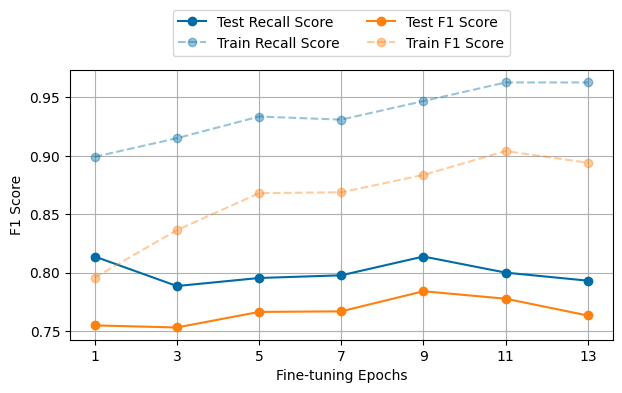

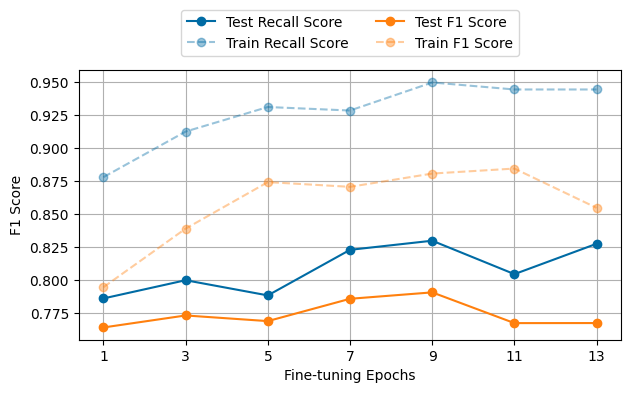

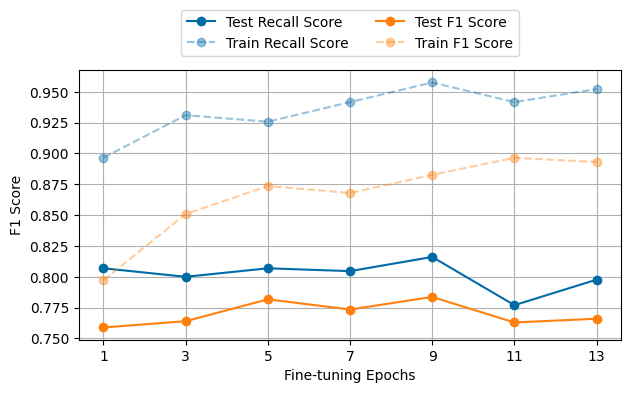

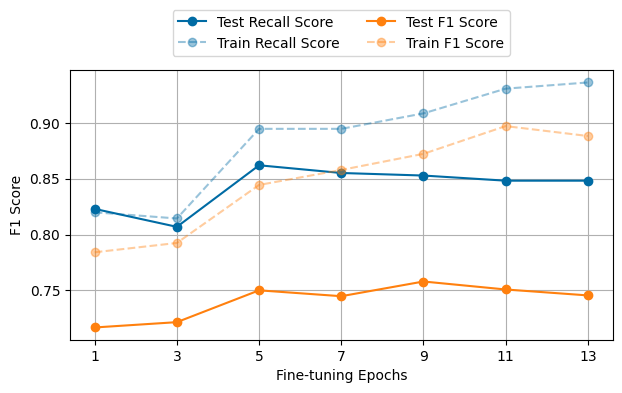

In [181]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Sample baseline DataFrame (contains one baseline for all experiments)
# Example format for baseline_df:
# baseline_df = pd.DataFrame({
#     'metric': ['precision', 'recall', 'f1'],
#     'score': [0.708502, 0.804598, 0.753498]
# })

plt.style.use('tableau-colorblind10')

# Create a plot for each experiment
experiment_names = results_df['experiment_name'].unique()

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for experiment in experiment_names:
    # Plot the f1 scores over epochs
    plt.figure(figsize=(7, 3.5))

    for metric_idx, metric in enumerate(["recall", "f1"]):
        # Extract the baseline F1 score
        baseline_f1 = baseline_df[baseline_df['metric'] == metric]['score'].values[0]
        # Filter out f1 metric from the DataFrame
        results_subset = results_df[results_df['metric'] == metric].copy()

        # Get the data for this specific experiment
        test_data = results_subset[(results_subset['experiment_name'] == experiment) & (results_subset['type'] == 'test')]
        train_data = results_subset[(results_subset['experiment_name'] == experiment) & (results_subset['type'] == 'train')]
        
        # Sort by epochs to ensure proper plotting
        test_data = test_data.sort_values('epochs')
        train_data = train_data.sort_values('epochs')
    
        plt.plot(test_data['epochs'], test_data['score'], label=f'Test {metric} Score'.title(), marker='o', c=color_cycle[metric_idx])
        plt.plot(train_data['epochs'], train_data['score'], label=f'Train {metric} Score'.title(), marker='o', linestyle='--', c=color_cycle[metric_idx], alpha=0.4)
    
        # Plot the baseline f1 score as a horizontal line
        # plt.axhline(y=baseline_f1, color='r', linestyle='--', label=f'Baseline F1 Score ({baseline_f1:.3f})')
    
    # Add labels and title
    plt.xlabel('Fine-tuning Epochs')
    plt.xticks(np.arange(1,max(results_df["epochs"])+1,2), np.arange(1,max(results_df["epochs"])+1,2))
    plt.ylabel('F1 Score')
    plt.legend()
    # Move the legend outside the plot at the top
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=False, fontsize=10)
    plt.grid(True)
    
    # Show the plot
    plt.show()

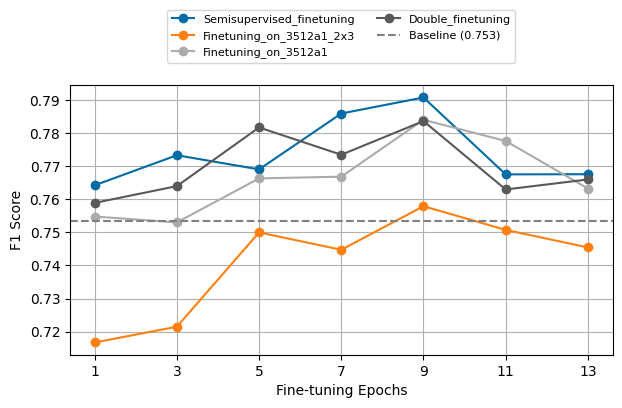

In [182]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Sample baseline DataFrame (contains one baseline for all experiments)
# Example format for baseline_df:
# baseline_df = pd.DataFrame({
#     'metric': ['precision', 'recall', 'f1'],
#     'score': [0.708502, 0.804598, 0.753498]
# })

plt.style.use('tableau-colorblind10') # "ggplot"

# Extract the baseline F1 score
baseline_f1 = baseline_df[baseline_df['metric'] == 'f1']['score']["mean"].values[0]

# Remove finetuning on dirty labels from the results
results_df = results_df[results_df['experiment_name'] != "finetuning_on_3512a1_2x3_with_bboxs_from_polygons"]
results_df = results_df[results_df['experiment_name'] != "finetuning_on_3512a1_2x3_with_computed_bboxs"]

# Filter out f1 metric from the DataFrame
results_subset = results_df[results_df['metric'] == 'f1'].copy()

# Create a plot for each experiment
experiment_names = list(results_subset['experiment_name'].unique())

# sort experiment names in reverse order
experiment_names.sort(reverse=True)

# Plot the f1 scores over epochs
plt.figure(figsize=(7, 3.5))

for exp_idx, experiment in enumerate(experiment_names):
    # Get the data for this specific experiment
    test_data = results_subset[(results_subset['experiment_name'] == experiment) & (results_subset['type'] == 'test')]
    
    # Sort by epochs to ensure proper plotting
    test_data = test_data.sort_values('epochs', ascending=True)
    
    # Plot the f1 scores over epochs
    plt.plot(test_data['epochs'], test_data['score'], label=f'{experiment}'.capitalize(), marker='o')
    
# Plot the baseline f1 score as a horizontal line
plt.axhline(y=baseline_f1, color='grey', linestyle='--', label=f'Baseline ({baseline_f1:.3f})')
    
# Add labels and title
plt.xlabel('Fine-tuning Epochs')
plt.ylabel('F1 Score')
plt.xticks(np.arange(1,max(results_df["epochs"])+1,2), np.arange(1,max(results_df["epochs"])+1,2))
plt.legend()
plt.grid(True)

# Move the legend outside the plot at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=False, fontsize=8)

# Show the plot
plt.savefig(ABS_EXPORT_PATH_FOR_FIGURES + "/single_seed_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

Visualize results over seeds.

In [183]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import copy

plt.style.use('tableau-colorblind10') # "ggplot"

# Extract the baseline F1 score
baseline_f1 = baseline_df[baseline_df['metric'] == 'f1']['score']["mean"].values[0]

# Remove finetuning on dirty labels from the results
curr_results_over_seeds = copy.deepcopy(results_over_seeds)
curr_results_over_seeds = curr_results_over_seeds[results_over_seeds['experiment_name'] != "finetuning_on_3512a1_2x3_with_bboxs_from_polygons"]
curr_results_over_seeds = curr_results_over_seeds[results_over_seeds['experiment_name'] != "finetuning_on_3512a1_2x3_with_computed_bboxs"]

# Filter out f1 metric from the DataFrame
results_subset = curr_results_over_seeds[curr_results_over_seeds['metric'] == 'f1'].copy()

# Create a plot for each experiment
experiment_names = list(results_subset['experiment_name'].unique())

# sort experiment names in reverse order
experiment_names.sort(reverse=True)

# Plot the f1 scores over epochs
plt.figure(figsize=(7, 3.5))

for exp_idx, experiment in enumerate(experiment_names):
    # Get the data for this specific experiment
    test_data = results_subset[(results_subset['experiment_name'] == experiment) & (results_subset['type'] == 'test')]
    
    # Sort by epochs to ensure proper plotting
    test_data = test_data.sort_values('epochs', ascending=True)
    
    # Plot the f1 scores over epochs
    plt.plot(test_data['epochs'], test_data['score']['mean'], label=f'{experiment}'.capitalize(), marker='o')
    
# Plot the baseline f1 score as a horizontal line
plt.axhline(y=baseline_f1, color='grey', linestyle='--', label=f'Baseline ({baseline_f1:.3f})')
    
# Add labels and title
plt.xlabel('Fine-tuning Epochs')
plt.ylabel('F1 Score')
plt.xticks(np.arange(1,max(results_df["epochs"])+1,2), np.arange(1,max(results_df["epochs"])+1,2))
plt.legend()
plt.grid(True)

# Move the legend outside the plot at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=False, fontsize=8)

# Show the plot
plt.savefig(ABS_EXPORT_PATH_FOR_FIGURES + "/multiple_seeds_model_comparisonl.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'metric'

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('tableau-colorblind10')  # Keep the style

# Extract the baseline F1 score
baseline_f1 = baseline_df[baseline_df['metric'] == 'f1']['score'].apply(lambda x: x['mean']).values[0]

# Remove fine-tuning on dirty labels from the results
curr_results_over_seeds = copy.deepcopy(results_over_seeds)
curr_results_over_seeds = curr_results_over_seeds[
    ~curr_results_over_seeds['experiment_name'].isin([
        "Fine-tuning on 3512a1-1 (unsup. bboxs from polygons)", 
        "Fine-tuning on 3512a1-1 (unsup. bboxs)", 
        "Fine-tuning on 3512a1-1 (manual bboxs)"
    ])
]

# Filter out f1 metric from the DataFrame
results_subset = curr_results_over_seeds[curr_results_over_seeds['metric'] == 'f1'].copy()

# Extract the 'mean' score from the 'score' column (assuming 'score' is a dictionary-like object)
results_subset['score_mean'] = results_subset['score'].apply(lambda x: x['mean'])

# Create a plot for each experiment
experiment_names = list(results_subset['experiment_name'].unique())
experiment_names.sort(reverse=True)

# Prepare a larger figure for grouped boxplots
plt.figure(figsize=(10, 6))

# Use seaborn to create boxplots
sns.set(style="whitegrid")

# Plot boxplot for each experiment grouped by epoch
sns.boxplot(
    x='epochs', 
    y='score_mean',  # Use the 'score_mean' column
    hue='experiment_name', 
    data=results_subset, 
    palette='colorblind', 
    showfliers=False
)

# Plot the baseline F1 score as a horizontal line
plt.axhline(y=baseline_f1, color='grey', linestyle='--', label=f'Baseline ({baseline_f1:.3f})')

# Add labels and title
plt.xlabel('Fine-tuning epochs')
plt.ylabel('F1 score')
plt.xticks(np.arange(1, max(results_subset['epochs']) + 1, 2), np.arange(1, max(results_subset['epochs']) + 1, 2))

# Add legend outside the plot at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False, fontsize=8)

# Show the grid
plt.grid(True)

# Save the figure
plt.savefig(ABS_EXPORT_PATH_FOR_FIGURES + "/boxplot_seeds_model_comparison.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

KeyError: 'mean'

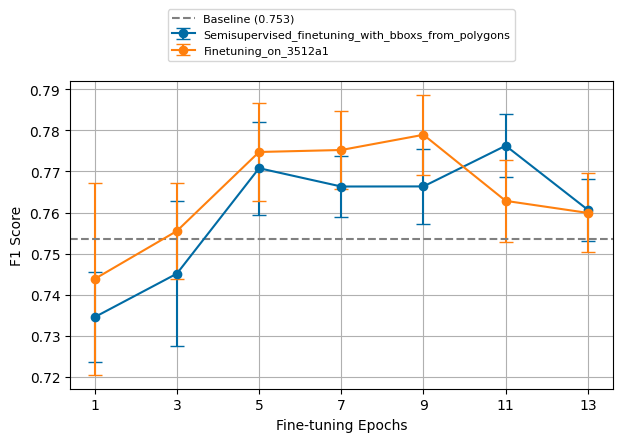

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('tableau-colorblind10')  # "ggplot"

# Extract the baseline F1 score
baseline_f1 = baseline_df[baseline_df['metric'] == 'f1']['score']["mean"].values[0]

# Remove finetuning on dirty labels from the results
curr_results_over_seeds = copy.deepcopy(results_over_seeds)

# select for specific experiments
selected_experiments = ["semisupervised_finetuning_with_bboxs_from_polygons", "finetuning_on_3512a1"]
curr_results_over_seeds = curr_results_over_seeds[curr_results_over_seeds['experiment_name'].isin(selected_experiments)]

# Filter out f1 metric from the DataFrame
results_subset = curr_results_over_seeds[curr_results_over_seeds['metric'] == 'f1'].copy()

# Create a plot for each experiment
experiment_names = list(results_subset['experiment_name'].unique())

# sort experiment names in reverse order
experiment_names.sort(reverse=True)

# Plot the f1 scores over epochs
plt.figure(figsize=(7, 4))

for exp_idx, experiment in enumerate(experiment_names):
    # Get the data for this specific experiment
    test_data = results_subset[(results_subset['experiment_name'] == experiment) & (results_subset['type'] == 'test')]
    
    # Sort by epochs to ensure proper plotting
    test_data = test_data.sort_values('epochs', ascending=True)
    
    # Plot the f1 scores over epochs with error bars
    plt.errorbar(
        test_data['epochs'], 
        test_data['score']['mean'], 
        yerr=test_data['score']['std'],  # Assuming 'std' is the column for standard deviation
        label=f'{experiment}'.capitalize(), 
        marker='o', 
        capsize=5  # This adds caps on the error bars for better visibility
    )
    
# Plot the baseline f1 score as a horizontal line
plt.axhline(y=baseline_f1, color='grey', linestyle='--', label=f'Baseline ({baseline_f1:.3f})')
    
# Add labels and title
plt.xlabel('Fine-tuning Epochs')
plt.ylabel('F1 Score')
plt.xticks(np.arange(1, max(results_subset["epochs"])+1, 2), np.arange(1, max(results_subset["epochs"])+1, 2))
plt.legend()
plt.grid(True)

# Move the legend outside the plot at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1, fancybox=True, shadow=False, fontsize=8)

# Show the plot
plt.savefig(ABS_EXPORT_PATH_FOR_FIGURES + "/multiple_seeds_model_comparison_with_error_bars.png", dpi=300, bbox_inches='tight')
plt.show()

### Bounding Boxes from Polygons

Bounding Box:
Xmin: 444848.1698217626
Xmax: 444858.1977170456
Ymin: 5792685.417262023
Ymax: 5792695.858025149


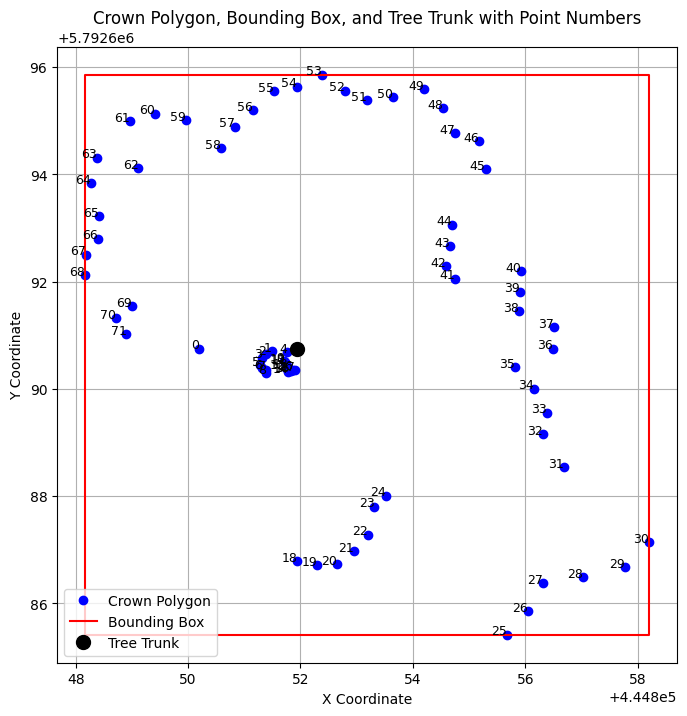

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def create_bounding_box(crown_polygon, ground_height_circle):
    sector_count = 72
    sector_angle = 2 * np.pi / sector_count

    # Adjust angles so that the first index points to negative x direction
    angles = np.arange(np.pi, 3 * np.pi, sector_angle)
    
    x_coords = []
    y_coords = []

    for i, distance in enumerate(crown_polygon):
        angle = angles[i]
        x = distance * np.cos(angle) + ground_height_circle['x']
        y = distance * np.sin(angle) + ground_height_circle['y']
        x_coords.append(x)
        y_coords.append(y)
    
    # Create bounding box
    xmin = min(x_coords)
    xmax = max(x_coords)
    ymin = min(y_coords)
    ymax = max(y_coords)
    
    return xmin, xmax, ymin, ymax, x_coords, y_coords

# Sample input data
crown_polygon = [
    1.7415436394627841, 0.45601390748167825, 0.5652861107894824, 0.6477758737065759,
    0.19479204292999877, 0.7283687687132725, 0.7319720025819307, 0.6831347943884167,
    0.7201304335647339, 0.32180311065958944, 0.3351272566102926, 0.34082349222018105,
    0.41184628837729026, 0.3720767304575501, 0.46743219026431065, 0.43851076755857765,
    0.39838208258264024, 0.3966842283346838, 3.9638302259557223, 4.044167514742917,
    4.075322948929477, 3.905188913550009, 3.6882457139576585, 3.2496450012954456,
    3.1659542433913, 6.51104082552721, 6.3846736903034875, 6.18094019547316,
    6.635116679394277, 7.1083187900717375, 7.223637464265023, 5.236441284515867,
    4.646529319713287, 4.603511688990121, 4.280738479347974, 3.8957984809215476,
    4.541764537320919, 4.591328721495137, 4.013852046638012, 4.101718972072638,
    4.239765576869887, 3.09147619135616, 3.0652492056237026, 3.320710539042518,
    3.5989073951095607, 4.73876744619167, 5.042446048691932, 4.898595446656932,
    5.185161628376563, 5.333941088425965, 4.995998960365992, 4.793216327407479,
    4.885327071627314, 5.126739515181219, 4.88642220213453, 4.814045716446036,
    4.519433042145146, 4.287674983500969, 3.986040874082964, 4.698032531700883,
    5.061075140177845, 5.175932536901533, 4.394011355161191, 5.035091671201709,
    4.799881624464174, 4.299639068886189, 4.101491399111789, 4.148499113265108,
    4.0141229671935355, 3.0370512649297954, 3.2766227319124566, 3.0500237666688017
]

ground_height_circle = {
    "radius": None,
    "x": 444851.9418634938,
    "y": 5792690.750794426
}

# Calculate bounding box
xmin, xmax, ymin, ymax, x_coords, y_coords = create_bounding_box(crown_polygon, ground_height_circle)

print(f"Bounding Box:")
print(f"Xmin: {xmin}")
print(f"Xmax: {xmax}")
print(f"Ymin: {ymin}")
print(f"Ymax: {ymax}")

# Plotting the bounding box, crown polygon, and tree trunk
plt.figure(figsize=(8, 8))
plt.plot(x_coords, y_coords, 'bo', label='Crown Polygon')

# Plotting bounding box
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-', label='Bounding Box')

# Plotting tree trunk
plt.plot(ground_height_circle['x'], ground_height_circle['y'], 'ko', markersize=10, label='Tree Trunk')

# Adding numbered points
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x, y, str(i), fontsize=9, ha='right')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Crown Polygon, Bounding Box, and Tree Trunk with Point Numbers')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()